# BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding

## ¿Qué es BERT?

- BERT (Bidirectional Encoder Representations from Transformers) es un modelo basado en la arquitectura Transformer diseñado para comprender el lenguaje natural.
- Su principal innovación es el preentrenamiento bidireccional profundo, lo que le permite considerar el contexto de ambas direcciones (izquierda y derecha) al mismo tiempo.

---

## Arquitectura Transformer y Bidireccionalidad

### ¿Qué es un Transformer?

- La arquitectura Transformer (Vaswani et al., 2017) está compuesta por bloques de codificadores (encoders) y decodificadores (decoders).
- BERT utiliza únicamente la parte de **encoders**.
- Cada encoder está formado principalmente por mecanismos de atención (self-attention) y capas feed-forward.

### Atención (Self-Attention)

- Permite que el modelo enfoque su "atención" en diferentes partes de la oración simultáneamente.
- Se representa mediante matrices **Q**, **K**, **V** (queries, keys, values), y se calcula la atención como un producto escalar escalado.

### Bidireccionalidad en BERT

- Modelos anteriores como GPT (Generative Pre-trained Transformer) son **unidireccionales**: predicen una palabra considerando solo el contexto izquierdo (pasado).
- BERT es **bidireccional profundo**, gracias a su tarea de preentrenamiento **Masked Language Modeling (MLM)**: el modelo enmascara palabras y predice las originales considerando todo el contexto (izquierda y derecha).

---

## Pre-entrenamiento vs Fine-tuning

### Pre-entrenamiento

- BERT se preentrena en grandes corpus sin etiquetas (Wikipedia y BooksCorpus).
- Se usan dos tareas principales:
  - **Masked Language Modeling (MLM):** se enmascaran los tokens aleatoriamente y el modelo debe predecirlos. (Inspirado en Cloze task)
  - **Next Sentence Prediction (NSP):** se le da al modelo un par de oraciones y se predice si la segunda sigue a la primera.

### Fine-tuning

- Después del preentrenamiento, se ajusta (fine-tuning) con datos etiquetados para tareas específicas (por ejemplo, clasificación, preguntas y respuestas, NER).
- Solo se necesita agregar una capa de salida pequeña, y todo el modelo se entrena en conjunto para la tarea final.

---

## Utilización de BERT para inferencia

### Modelo preentrenado

- BERT se puede usar directamente con pesos preentrenados publicados en repositorios como Hugging Face (transformers).
- Durante la inferencia, se puede usar para:
  - Extraer embeddings de palabras o frases.
  - Realizar tareas como clasificación, análisis de sentimiento, QA, etc.

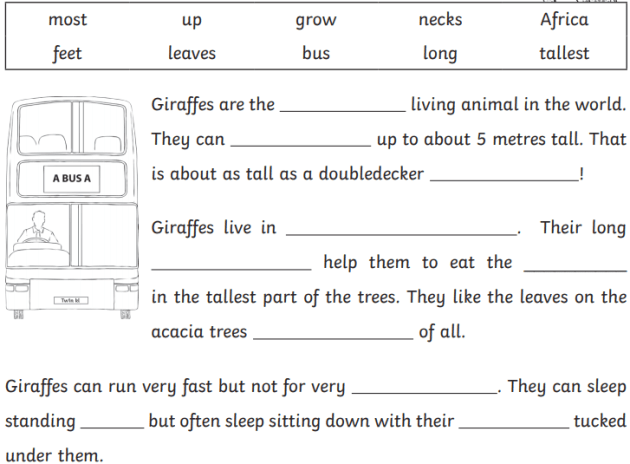

In [1]:
from IPython.display import Image
Image(filename='images/cloze_task_example.png')


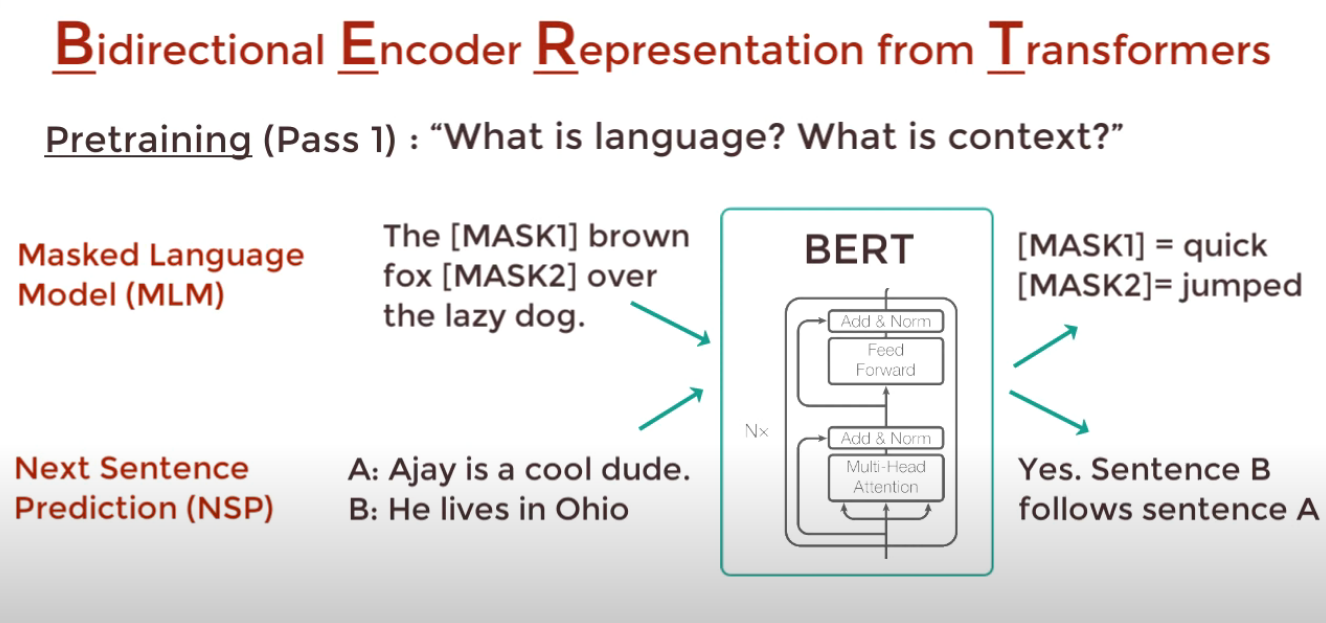

In [2]:
Image(filename='images/Bert_training.png')


##  Procesamiento de texto
1.  Al inicio se incluye siempre un token de clasificación (CLS) y para separar una frase de otra se incluye el token de separación (SEP). En un momento veremos el papel de estos tokens

2. Después, por cada token se obtienen tres representaciones:

    -   Un embedding, que representa el token como un vector y una codificación posicional, como las usadas en la red transformer original. Recordemos que la codificación posicional es necesaria para indicarle al bloque de codificación la posición relativa de cada palabra dentro de la frase, pues todas las palabras son procesadas de manera simultánea por la red

    -   Adicional a estas dos codificaciones se añade un embedding que indica a qué segmento pertenece la frase: la primera frase (antes del separador) se codifica con un embedding diferente al de la segunda frase.

    -   Finalmente se suman estas tres representaciones y los vectores resultantes son procesados por BERT

In [3]:
pip install transformers

  Using cached transformers-4.53.1-py3-none-any.whl.metadata (40 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.21.2-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
Using cached transformers-4.53.1-py3-none-any.whl (10.8 MB)
Using cached huggingface_hub-0.33.2-py3-none-any.whl (515 kB)
Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl (308 kB)
Using cached tokenizers-0.21.2-cp39-abi3-win_amd64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from transformers import TFBertModel, AutoTokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Dropout
from keras.models import Model
from keras.optimizers import Adam


c:\Users\newma\anaconda3\envs\IMA543_2025_1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  Detección de toxicidad en tweets con BERT (Davidson dataset)

## Dataset

Usaremos el dataset de Davidson et al., que contiene tweets en inglés etiquetados originalmente como:

- 0 = Hate speech
- 1 = Offensive language
- 2 = Neither (ninguno)

Para simplificar el problema en este ejemplo práctico, convertimos las etiquetas en **binarias**:

- **Tóxico (label = 1):** Si la clase original es 0 (hate speech) o 1 (offensive).
- **No tóxico (label = 0):** Si la clase original es 2 (neither).

Esto nos permitirá entrenar un clasificador binario para distinguir mensajes tóxicos de no tóxicos.


In [2]:
df = pd.read_csv("labeled_data.csv")


In [3]:
# Agrupar etiquetas
df['label'] = df['class'].apply(lambda x: 1 if x in [0, 1] else 0)

# Distribución
print(df['label'].value_counts())


label
1    20620
0     4163
Name: count, dtype: int64


In [4]:
import re

def preprocess(text_string):
    """
    Acepta un string y reemplaza:
    1) URLs por 'URLHERE'
    2) Menciones por 'MENTIONHERE'
    3) Espacios múltiples por uno solo
    """
    space_pattern = r'\s+'
    giant_url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    mention_regex = r'@[\w\-]+'
    
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    
    return parsed_text.strip()


In [5]:
df['clean_tweet'] = df['tweet'].apply(preprocess)
texts = df['clean_tweet'].tolist()
labels = df['label'].tolist()


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenizar con truncation y padding
encodings = tokenizer(texts, truncation=True, padding=True, max_length=64)


In [7]:
input_ids = tf.constant(encodings['input_ids'])
attention_masks = tf.constant(encodings['attention_mask'])
labels_tf = tf.constant(labels)

In [8]:

# Convertir tensores a numpy
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()
labels_np = labels_tf.numpy()

# Dividir usando sklearn
train_ids, val_ids, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids_np, attention_masks_np, labels_np, test_size=0.2, random_state=42
)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_ids,
    'attention_mask': train_masks
}, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_ids,
    'attention_mask': val_masks
}, val_labels))

# Batching
batch_size = 16
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


In [10]:
bert_model = TFBertModel.from_pretrained("bert-base-cased")

inputs = {
    'input_ids': Input(shape=(None,), dtype=tf.int32, name="input_ids"),
    'attention_mask': Input(shape=(None,), dtype=tf.int32, name="attention_mask")
}

pooled_output = bert_model(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask']
)[1]

x = Dropout(0.3)(pooled_output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=output)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were 

In [11]:
optimizer = Adam(learning_rate=2e-5)

model.compile(optimizer=optimizer, loss="SparseCategoricalCrossentropy", metrics=['accuracy'])

# Entrenar


In [12]:
history = model.fit(x=train_dataset, validation_data=val_dataset, epochs=2)


Epoch 1/2
1240/1240 [==============================] - 328s 249ms/step - loss: 0.1644 - accuracy: 0.9375 - val_loss: 0.1220 - val_accuracy: 0.9597
Epoch 2/2
1240/1240 [==============================] - 389s 314ms/step - loss: 0.0989 - accuracy: 0.9656 - val_loss: 0.1215 - val_accuracy: 0.9578


In [13]:
# Texto de prueba
test_text = "You are the worst person ever!"

# Tokenizar
test_enc = tokenizer(
    test_text,
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="tf"
)

# Predecir
pred = model.predict({
    'input_ids': test_enc['input_ids'],
    'attention_mask': test_enc['attention_mask']
})

# Convertir softmax a clase
pred_label = tf.argmax(pred, axis=1).numpy()[0]

# Mostrar resultados
print("Texto:", test_text)
print("Predicción (0 = no tóxico, 1 = tóxico):", pred_label)
print("Probabilidades:", pred[0])


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


1/1 [==============================] - 3s 3s/step
Texto: You are the worst person ever!
Predicción (0 = no tóxico, 1 = tóxico): 0
Probabilidades: [0.837495   0.16250499]


In [14]:
texts = [
    "I love your work, you're amazing!",          # No tóxico esperado
    "Shut up and go away, you idiot!",            # Tóxico esperado
    "Thank you for your help!",                   # No tóxico esperado
    "You are a horrible, disgusting person.",     # Tóxico esperado
]

for text in texts:
    test_enc = tokenizer(text, truncation=True, padding=True, max_length=64, return_tensors="tf")
    pred = model.predict({
        'input_ids': test_enc['input_ids'],
        'attention_mask': test_enc['attention_mask']
    })
    pred_label = tf.argmax(pred, axis=1).numpy()[0]
    print(f"Texto: '{text}' → Predicción: {pred_label} (0 = no tóxico, 1 = tóxico)")


1/1 [==============================] - 3s 3s/step
Texto: 'I love your work, you're amazing!' → Predicción: 0 (0 = no tóxico, 1 = tóxico)
1/1 [==============================] - 0s 156ms/step
Texto: 'Shut up and go away, you idiot!' → Predicción: 1 (0 = no tóxico, 1 = tóxico)
1/1 [==============================] - 0s 108ms/step
Texto: 'Thank you for your help!' → Predicción: 0 (0 = no tóxico, 1 = tóxico)
1/1 [==============================] - 0s 92ms/step
Texto: 'You are a horrible, disgusting person.' → Predicción: 0 (0 = no tóxico, 1 = tóxico)


### Fuentes consultadas
-   [BERT Neural Network - EXPLAINED!](https://www.youtube.com/watch?v=xI0HHN5XKDo)

-   [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

-   [BERT: el inicio de una nueva era en el Natural Language Processing](https://codificandobits.com/blog/bert-en-el-natural-language-processing/)
